## Modelagem

Nesta série de scripts iremos começar o processo de modelagem. O método que mais se aplica ao nosso conjunto de dados é a análise de dados em painel. Aqui iremos aplicar este primeiro método e depois iremos explorar outras opções. Usei o exemplo desse [link](https://bashtage.github.io/linearmodels/panel/examples/examples.html).

Links:
1. [A Guide to Panel Data Regression: Theoretics and Implementation with Python](https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8)

In [15]:
# Carregar librarias
import pandas as pd
import statsmodels.api as sm
from linearmodels.datasets import wage_panel
from linearmodels.panel import PooledOLS
from linearmodels.panel import RandomEffects
from linearmodels.panel import BetweenOLS
from linearmodels.panel import compare
from scipy.stats import zscore
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Carregar dataset
data_sugarcane = pd.read_csv("new_data_all.csv", sep =  ',').drop(['Unnamed: 0', 'AP'], axis = 1)

In [49]:
# Visão dos dados
data_sugarcane.head()

,CD_MUN,MUN,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST
0,3500105,Adamantina (SP),2000,50000.0,7000.0,350000.0,6244.0,704,5174.465583,4047,165.814275,163,288,91,15244
1,3500204,Adolfo (SP),2000,NaN,NaN,NaN,NaN,716,4079.833442,5245,255.016962,162,290,94,15090
2,3500303,Aguaí (SP),2000,80000.0,5250.0,420000.0,7493.0,675,5613.906725,8672,398.974009,151,272,109,15133
3,3500550,Águas de Santa Bárbara (SP),2000,NaN,NaN,NaN,NaN,776,5388.291761,8146,245.525207,142,270,95,15148
4,3500709,Agudos (SP),2000,70000.0,8000.0,560000.0,9990.0,746,5968.640067,9080,247.830150,146,274,94,15097


In [19]:
# Padronizar as variaveis (z-score)
cols = ['AC', 'QP', 'VP', 'AET', 'NDVI', 'NPP', 'SOIL', 'TMIN', 'TMMX', 'PR', 'LST']

In [23]:
data_sugarcane[cols] = data_sugarcane[cols].apply(zscore, nan_policy = 'omit')

In [24]:
data_sugarcane

,CD_MUN,MUN,Year,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST
0,3500105,Adamantina (SP),2000,50000.0,-0.242033,-0.468792,-0.615051,-0.432465,-1.371257,-1.833368,-1.307221,0.308097,0.412651,-0.774360,0.968238
1,3500204,Adolfo (SP),2000,NaN,NaN,NaN,NaN,-0.289158,-3.479334,-1.347342,-0.535958,0.228566,0.536186,-0.623899,-0.577286
2,3500303,Aguaí (SP),2000,80000.0,-0.398108,-0.391970,-0.590178,-0.778791,-0.524967,0.042982,0.708721,-0.646272,-0.575630,0.128405,-0.145743
3,3500550,Águas de Santa Bárbara (SP),2000,NaN,NaN,NaN,NaN,0.427377,-0.959463,-0.170415,-0.618025,-1.362049,-0.699166,-0.573745,0.004795
4,3500709,Agudos (SP),2000,70000.0,-0.152847,-0.238325,-0.540453,0.069109,0.158190,0.208506,-0.598096,-1.043926,-0.452095,-0.623899,-0.507034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10180,3556958,Vitória Brasil (SP),2020,100000.0,-0.835117,-0.814493,-0.681085,-3.226952,-1.050133,-1.205754,-1.092342,0.785281,0.906792,-2.178660,2.604084
10181,3557105,Votuporanga (SP),2020,70000.0,0.212814,0.076647,0.491901,-3.035876,-0.678504,-1.104330,-0.922799,1.023874,1.215630,-2.078353,2.052111
10182,3557154,Zacarias (SP),2020,80000.0,-0.152847,-0.150528,0.286569,-2.940338,-2.105923,-0.766384,-1.230747,0.705751,0.906792,-2.228814,0.255691
10183,3557204,Chavantes (SP),2020,78960.0,-0.018712,-0.029329,0.471071,-1.566979,0.453527,0.165908,-1.469186,-0.328149,-0.019722,-1.376203,0.115189


In [50]:
# Converter o ano para categórico
year_sugar = pd.Categorical(data_sugarcane.Year)
year_sugar

[2000, 2000, 2000, 2000, 2000, ..., 2020, 2020, 2020, 2020, 2020]
Length: 10185
Categories (21, int64): [2000, 2001, 2002, 2003, ..., 2017, 2018, 2019, 2020]

In [51]:
# Criar o index utilizando o ano e o código do municipio
data_sugar = data_sugarcane.set_index(['CD_MUN', 'Year'])

In [52]:
# Adicionar a coluna do ano
data_sugar['Year'] = year_sugar

In [53]:
# Info
data_sugar.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10185 entries, (3500105, 2000) to (3557303, 2020)
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   MUN     10185 non-null  object  
 1   Yield   9525 non-null   float64 
 2   AC      9527 non-null   float64 
 3   QP      9527 non-null   float64 
 4   VP      9527 non-null   float64 
 5   AET     10185 non-null  int64   
 6   NDVI    10185 non-null  float64 
 7   NPP     10185 non-null  int64   
 8   SOIL    10185 non-null  float64 
 9   TMIN    10185 non-null  int64   
 10  TMMX    10185 non-null  int64   
 11  PR      10185 non-null  int64   
 12  LST     10185 non-null  int64   
 13  Year    10185 non-null  category
dtypes: category(1), float64(6), int64(6), object(1)
memory usage: 1.1+ MB


In [54]:
# Selecionar as variáveis que serão utilizadas na modelagem
exog_vars_sugar = ['AC', 'QP', 'VP', 'AET', 'NDVI', 'NPP', 'SOIL', 'TMIN', 'TMMX', 'PR', 'LST','Year']

In [55]:
# Adicionar a constante
exog_sugar = sm.add_constant(data_sugar[exog_vars_sugar])
exog_sugar.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10185 entries, (3500105, 2000) to (3557303, 2020)
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   const   10185 non-null  float64 
 1   AC      9527 non-null   float64 
 2   QP      9527 non-null   float64 
 3   VP      9527 non-null   float64 
 4   AET     10185 non-null  int64   
 5   NDVI    10185 non-null  float64 
 6   NPP     10185 non-null  int64   
 7   SOIL    10185 non-null  float64 
 8   TMIN    10185 non-null  int64   
 9   TMMX    10185 non-null  int64   
 10  PR      10185 non-null  int64   
 11  LST     10185 non-null  int64   
 12  Year    10185 non-null  category
dtypes: category(1), float64(6), int64(6)
memory usage: 1016.1 KB


In [56]:
# Criar e rodar o modelo - Simple OLS
mod_sugar = PooledOLS(data_sugar.Yield, exog_sugar)
pooled_res_sugar = mod_sugar.fit()
print(pooled_res_sugar)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  Yield   R-squared:                        0.3641
Estimator:                  PooledOLS   R-squared (Between):              0.4189
No. Observations:                9525   R-squared (Within):               0.3365
Date:                Sun, Aug 07 2022   R-squared (Overall):              0.3641
Time:                        12:57:25   Log-likelihood                -1.016e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      175.31
Entities:                         485   P-value                           0.0000
Avg Obs:                       19.639   Distribution:                 F(31,9493)
Min Obs:                       13.000                                           
Max Obs:                       21.000   F-statistic (robust):             175.31
                            

In [57]:
# Criar e rodar o modelo  - Random effects
mod_random_sugar = RandomEffects(data_sugar.Yield, exog_sugar)
re_res_sugar = mod_random_sugar.fit()
print(re_res_sugar)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Yield   R-squared:                        0.3574
Estimator:              RandomEffects   R-squared (Between):              0.3833
No. Observations:                9525   R-squared (Within):               0.3421
Date:                Sun, Aug 07 2022   R-squared (Overall):              0.3570
Time:                        12:57:28   Log-likelihood                -1.002e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      170.28
Entities:                         485   P-value                           0.0000
Avg Obs:                       19.639   Distribution:                 F(31,9493)
Min Obs:                       13.000                                           
Max Obs:                       21.000   F-statistic (robust):             161.04
                            

In [58]:
# Decomponer a variancia
re_res_sugar.variance_decomposition

Effects                   2.714671e+07
Residual                  8.028244e+07
Percent due to Effects    2.526941e-01
Name: Variance Decomposition, dtype: float64

Rodar o modelo sem considerar o ano (Between OLS)

In [59]:
# Excluir o ano das variavéis
exog_vars_sugar_sem_year = ['AC', 'QP', 'VP', 'AET', 'NDVI', 'NPP', 'SOIL', 'TMIN', 'TMMX', 'PR', 'LST']

In [60]:
# Adicionar a constante
exog_sem_year = sm.add_constant(data_sugar[exog_vars_sugar_sem_year])

In [61]:
# Criar e rodar o modelo sem o efeito do ano
mod_sem_year = BetweenOLS(data_sugar.Yield, exog_sem_year)
be_res_sugar = mod_sem_year.fit(reweight = True)
print(be_res_sugar)

                         BetweenOLS Estimation Summary                          
Dep. Variable:                  Yield   R-squared:                        0.4287
Estimator:                 BetweenOLS   R-squared (Between):              0.4252
No. Observations:                 485   R-squared (Within):               0.2081
Date:                Sun, Aug 07 2022   R-squared (Overall):              0.2777
Time:                        12:57:37   Log-likelihood                   -4867.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      67.797
Entities:                         485   P-value                           0.0000
Avg Obs:                       19.639   Distribution:                  F(11,473)
Min Obs:                       13.000                                           
Max Obs:                       21.000   F-statistic (robust):             32.270
                            

## Comparar os modelos

In [62]:
print(compare({"BE": be_res_sugar,'RE': re_res_sugar, "Pooled": pooled_res_sugar}))

                        Model Comparison                       
                                BE              RE       Pooled
---------------------------------------------------------------
Dep. Variable                Yield           Yield        Yield
Estimator               BetweenOLS   RandomEffects    PooledOLS
No. Observations               485            9525         9525
Cov. Est.               Unadjusted      Unadjusted   Unadjusted
R-squared                   0.4287          0.3574       0.3641
R-Squared (Within)          0.2081          0.3421       0.3365
R-Squared (Between)         0.4252          0.3833       0.4189
R-Squared (Overall)         0.2777          0.3570       0.3641
F-statistic                 67.797          170.28       175.31
P-value (F-stat)            0.0000          0.0000       0.0000
===================== ============ =============== ============
const                   -2.429e+05       8.044e+04   -1.085e+05
                         (-1.9834)      

In [39]:
#Import and preprocess data
import pandas as pd

dat_new = pd.read_csv('new_data_all.csv', sep = ',', index_col = ['CD_MUN', 'Year']).drop(['Unnamed: 0', 'AP'], axis = 1)
dat_new


,,MUN,Yield,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST
CD_MUN,Year,,,,,,,,,,,,,
3500105,2000,Adamantina (SP),50000.0,7000.0,350000.0,6244.0,704,5174.465583,4047,165.814275,163,288,91,15244
3500204,2000,Adolfo (SP),NaN,NaN,NaN,NaN,716,4079.833442,5245,255.016962,162,290,94,15090
3500303,2000,Aguaí (SP),80000.0,5250.0,420000.0,7493.0,675,5613.906725,8672,398.974009,151,272,109,15133
3500550,2000,Águas de Santa Bárbara (SP),NaN,NaN,NaN,NaN,776,5388.291761,8146,245.525207,142,270,95,15148
3500709,2000,Agudos (SP),70000.0,8000.0,560000.0,9990.0,746,5968.640067,9080,247.830150,146,274,94,15097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556958,2020,Vitória Brasil (SP),100000.0,350.0,35000.0,2928.0,470,5341.210829,5594,190.666667,169,296,63,15407
3557105,2020,Votuporanga (SP),70000.0,12100.0,847000.0,61831.0,486,5534.181546,5844,210.275741,172,301,65,15352
3557154,2020,Zacarias (SP),80000.0,8000.0,640000.0,51520.0,494,4792.985554,6677,174.659113,168,296,62,15173


In [40]:
years = dat_new.index.get_level_values('Year').to_list()
years

[2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,

In [63]:

dat_new['Year'] = pd.Categorical(years)
exog_sugar

,,const,AC,QP,VP,AET,NDVI,NPP,SOIL,TMIN,TMMX,PR,LST,Year
CD_MUN,Year,,,,,,,,,,,,,
3500105,2000,1.0,7000.0,350000.0,6244.0,704,5174.465583,4047,165.814275,163,288,91,15244,2000
3500204,2000,1.0,NaN,NaN,NaN,716,4079.833442,5245,255.016962,162,290,94,15090,2000
3500303,2000,1.0,5250.0,420000.0,7493.0,675,5613.906725,8672,398.974009,151,272,109,15133,2000
3500550,2000,1.0,NaN,NaN,NaN,776,5388.291761,8146,245.525207,142,270,95,15148,2000
3500709,2000,1.0,8000.0,560000.0,9990.0,746,5968.640067,9080,247.830150,146,274,94,15097,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556958,2020,1.0,350.0,35000.0,2928.0,470,5341.210829,5594,190.666667,169,296,63,15407,2020
3557105,2020,1.0,12100.0,847000.0,61831.0,486,5534.181546,5844,210.275741,172,301,65,15352,2020
3557154,2020,1.0,8000.0,640000.0,51520.0,494,4792.985554,6677,174.659113,168,296,62,15173,2020


In [64]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm

# Criar e rodar o modelo - Simple OLS
mod_sugar = PooledOLS(dat_new.Yield, exog_sugar)
pooled_res_sugar = mod_sugar.fit(cov_type='clustered', cluster_entity=True)
print(pooled_res_sugar)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  Yield   R-squared:                        0.3641
Estimator:                  PooledOLS   R-squared (Between):              0.4189
No. Observations:                9525   R-squared (Within):               0.3365
Date:                Sun, Aug 07 2022   R-squared (Overall):              0.3641
Time:                        12:57:53   Log-likelihood                -1.016e+05
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      175.31
Entities:                         485   P-value                           0.0000
Avg Obs:                       19.639   Distribution:                 F(31,9493)
Min Obs:                       13.000                                           
Max Obs:                       21.000   F-statistic (robust):             20.196
                            

In [65]:
fittedvals_pooled_OLS = pooled_res_sugar.predict().fitted_values
residuals_pooled_OLS = pooled_res_sugar.resids

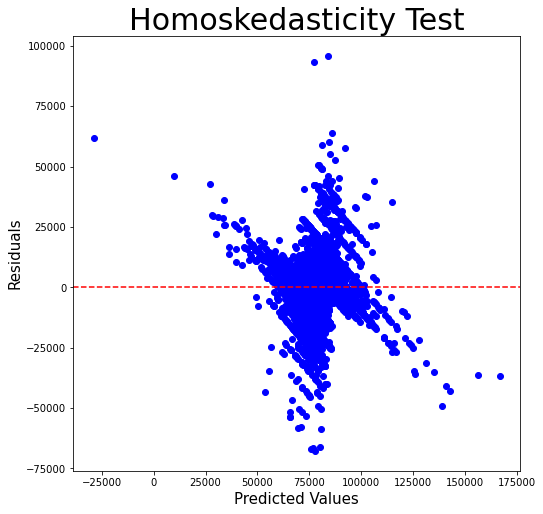

In [66]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [67]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects

# random effects model
model_re = RandomEffects(dat_new.Yield, exog_sugar) 
re_res = model_re.fit() 

 
#print results
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                  Yield   R-squared:                        0.3574
Estimator:              RandomEffects   R-squared (Between):              0.3833
No. Observations:                9525   R-squared (Within):               0.3421
Date:                Sun, Aug 07 2022   R-squared (Overall):              0.3570
Time:                        12:58:02   Log-likelihood                -1.002e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      170.28
Entities:                         485   P-value                           0.0000
Avg Obs:                       19.639   Distribution:                 F(31,9493)
Min Obs:                       13.000                                           
Max Obs:                       21.000   F-statistic (robust):             161.04
                            

In [68]:
model_fe = PanelOLS(dat_new.Yield, exog_sugar) 
fe_res = model_fe.fit()
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  Yield   R-squared:                        0.3641
Estimator:                   PanelOLS   R-squared (Between):              0.4189
No. Observations:                9525   R-squared (Within):               0.3365
Date:                Sun, Aug 07 2022   R-squared (Overall):              0.3641
Time:                        12:58:08   Log-likelihood                -1.016e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      175.31
Entities:                         485   P-value                           0.0000
Avg Obs:                       19.639   Distribution:                 F(31,9493)
Min Obs:                       13.000                                           
Max Obs:                       21.000   F-statistic (robust):             175.31
                            

In [69]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
    b = fe.params
    B = re.params
    v_b = fe.cov
    v_B = re.cov
    df = b[np.abs(b) < 1e8].size
    chi2 = np.dot((b-B).T, la.inv(v_b-v_B).dot(b-B)) 
    pval = stats.chi2.sf(chi2, df)
    return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print('chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

chi-Squared: -204.12346607258962
degrees of freedom: 32
p-Value: 1.0


Since the p-value is very small, the null hypothesis can be rejected. Accordingly, the FE-model seems to be the most suitable, because we clearly have endogeneity in our model.

The null hypothesis that individual effects are uncorrelated with the other regressors (aka random effects preferred) is rejected.